In [1]:
from cities.deployment.tracts_minneapolis.predict_new import TractsModelPredictor

from cities.utils.plot_ts import (plot_coefs, summarize_time_series,
                                  plot_model_summary, plot_selected_series)

from chirho.indexed.ops import IndexSet, gather, indices_of

from chirho.counterfactual.handlers import MultiWorldCounterfactual
from chirho.interventional.handlers import do

from cities.utils.data_loader import db_connection
import time
import torch
import pyro


import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
# start = time.time()
# with db_connection() as conn:
#     predictor = TractsModelPredictor(conn)

# end = time.time()   
# print("Time to load predictor: ", end - start)

In [3]:
#print(predictor.factual_samples['destandardized_housing_units_cumulative'].shape)

factual_intervention = {"radius_blue": 106.7, "limit_blue": 0, "radius_yellow_line": 402.3, "radius_yellow_stop": 804.7, "limit_yellow": 0.5, "reform_year": 2015}
extreme_intervention = {"radius_blue": 1400, "limit_blue": 0, "radius_yellow_line": 2640, "radius_yellow_stop": 4000, "limit_yellow": 0.3, "reform_year": 2012}


start = time.time()
with db_connection() as conn:
    predictor = TractsModelPredictor(conn)
    # factual_intervention = predictor._tracts_intervention(conn, **factual_intervention)
    # extreme_intervention = predictor._tracts_intervention(conn, **extreme_intervention)

    end_loading = time.time()
    prediction_factual = predictor.predict_cumulative(conn, factual_intervention)
    prediction_extreme = predictor.predict_cumulative(conn, extreme_intervention)

end = time.time()   

print("Time to load:", end_loading - start)
print("Time to make two predictions: ", end - end_loading)
      
prediction_factual.keys()



Time to load: 13.181069374084473
Time to make two predictions:  15.318738460540771


dict_keys(['census_tracts', 'years', 'housing_units_observed', 'housing_units_factual_means', 'housing_units_factual_low', 'housing_units_factual_high', 'housing_units_factual_samples', 'housing_units_intervened_means', 'housing_units_intervened_low', 'housing_units_intervened_high', 'housing_units_intervened_samples'])

In [4]:
predictor.intervened_summary.keys()

dict_keys(['mean_pred', 'mean_low', 'mean_high', 'series_mean_pred', 'series_low_pred', 'series_high_pred'])

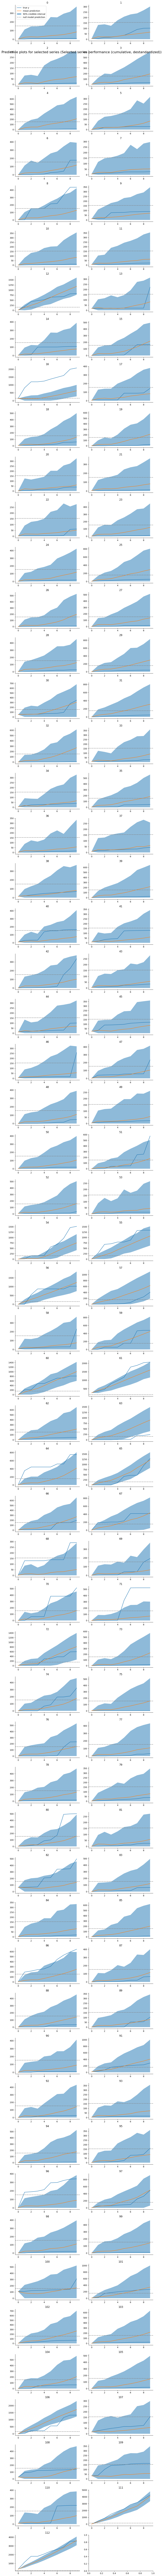

In [5]:

plot_selected_series(
    predictor.factual_summary,
    y_true = predictor.observed_housing_cumulative,
    intervened_summary=predictor.intervened_summary,
    selected_series=range(113),
    title="Selected series performance (cumulative, destandardized)",
    plot_null=True,
    #path = "ts_selected_series_destandardized_cumulative.png",
    add_metrics = False,
)


In [ ]:
predictor.factual_samples['destandardized_housing_units_cumulative']

[2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2020,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2020,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2020,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2020,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2020,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2020,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2020,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2020,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2020,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2020,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2020,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2020,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2020,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2020,
 2011,
 2012,
 2013,